In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import softmax
import pandas as pd

def slog(X, tol=1e-300):
    """Safe log function (avoids underflow for small values)

    ### Parameters
    1. X : str
        - input you wish to take the log of

    ### Returns
    - log(X)
        - the log of the maximum between X and tol
    """
    return np.log(np.clip(X, a_min=tol, a_max=None))


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


class eSPA_demo(BaseEstimator, ClassifierMixin):

    def __init__(self, K=3, epsC=1e-3, epsW=1e-2, max_iters=500, tol=1e-8):
        self.K = K
        self.epsC = epsC
        self.epsW = epsW
        self.max_iters = max_iters
        self.tol = tol
        self._is_fitted = False
        
    def fit(self, X, y, N_anneal=16, criterion = "auc"):
        T, D = X.shape
        self.classes = np.unique(y)

        # Convert to one-hot
        Pi = np.zeros((T, len(self.classes)))
        for idx, c in enumerate(self.classes):
            Pi[y == c, idx] = 1

        best_crit = -np.inf
        best_model = {}

        for trial in range(N_anneal):
            # ----- Initialisierung ----- (diese ist zufällig, das ist der Punkt warum wir öfters fitten)
            C = X[np.random.randint(0, T, self.K), :]
            G = np.zeros((T, self.K))
            W = np.random.rand(D) + 0.1
            W /= W.sum()
            L = np.random.rand(len(self.classes), self.K)
            losses = []

            for i in range(self.max_iters):
                # Update G
                G = cdist(X, C, "sqeuclidean", w=W)
                G -= self.epsC * (np.matmul(Pi, slog(L)))
                mins = np.argmin(G, 1)
                G[:, :] = 0
                for m in np.unique(mins):
                    G[mins == m, m] = 1

                # Remove empty boxes
                emptyboxes = G.sum(0) == 0
                if any(emptyboxes):
                    G = G[:, ~emptyboxes]
                    C = C[~emptyboxes, :]
                    L = L[:, ~emptyboxes]
                    if G.shape[1] == 0:
                        break  # all clusters collapsed
                    self.K = G.shape[1]

                # Update W
                W[:] = 0
                for k in range(self.K):
                    W += np.sum(G[:, [k]] * ((X - C[[k], :]) ** 2), 0)
                W = softmax(-W / (T * self.epsW))

                # Update C
                C = (G.T @ X)
                C /= G.sum(0).reshape(-1, 1)

                # Update L
                L = Pi.T @ G
                sums = L.sum(0)
                sums[sums == 0] = 1
                L /= sums

                # Calculate loss
                Lval = (W * ((X - G @ C) ** 2).sum(0)).sum() / T
                Lval -= (self.epsC / T) * np.sum(Pi * (slog(L) @ G.T).T)
                Lval += self.epsW * np.dot(W, slog(W))
                losses.append(Lval)

                if i > 1 and abs(losses[-2] - losses[-1]) < self.tol:
                    break

            # ----- Simulated Annealing Auswahl -----
            # Niumm MOdell mit bester accuracy/roc auf den Trainingsdaten
            G_pred = cdist(X, C, "sqeuclidean", w=W)
            mins = np.argmin(G_pred, axis=1)
            G_pred[:, :] = 0
            for m in np.unique(mins):
                G_pred[mins == m, m] = 1
            probs = L @ G_pred.T
            preds = np.argmax(probs, axis=0)
            if criterion == "accuracy":
                acc = accuracy_score(y, preds)
                if acc > best_crit:
                    best_crit = acc
                    best_model = {
                        'W': W.copy(),
                        'C': C.copy(),
                        'G': G.copy(),
                        'L': L.copy(),
                        'losses': losses.copy(),
                        'iterations': i
                    }
            if criterion == "auc":
                auc_val = roc_auc_score(y, probs[1,:])
                if auc_val > best_crit:
                    best_crit = auc_val
                    best_model = {
                        'W': W.copy(),
                        'C': C.copy(),
                        'G': G.copy(),
                        'L': L.copy(),
                        'losses': losses.copy(),
                        'iterations': i
                    }
                


        # Setze bestes Modell
        self.W = best_model['W']
        self.C = best_model['C']
        self.G = best_model['G']
        self.L = best_model['L']
        self.losses = best_model['losses']
        self.iterations = best_model['iterations']
        self._is_fitted = True
        return self


    def predict_proba(self, X):
        G = cdist(X,self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, 1)
        G[:,:] = 0
        for m in np.unique(mins):
            G[mins==m,m] = 1
        return self.L @ G.T #M times T matrix
        
    def predict(self, X):
        G = cdist(X, self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, axis=1)
        G[:, :] = 0
        for m in np.unique(mins):
            G[mins == m, m] = 1
        probs = self.L @ G.T  # shape (num_classes, num_samples)
        preds = np.argmax(probs, axis=0)  # max Wahrscheinlichkeit pro Sample
        return preds

In [44]:
from sklearn.metrics import make_scorer, roc_auc_score
X = pd.read_pickle("X.pkl")
X = X.values
y = pd.read_pickle("y.pkl")
y = np.ravel(y)
mod = eSPA_demo(K=6, epsC=1e-1, epsW=1)
mod.fit(X,y, criterion = "auc")
predprob = mod.predict_proba(X)

print(y.shape)
score = roc_auc_score(y, predprob[1,:])
print(score)
mod.W

(285,)
0.7916185971389018


array([0.06422821, 0.10961069, 0.08613428, 0.10859829, 0.06001242,
       0.11004005, 0.07243092, 0.08557389, 0.08154204, 0.11016164,
       0.11166756])

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold

inner_cv = StratifiedKFold(n_splits=5)
param_grid = {
    'K': [2, 3, 4,5,6,7,8,9,10],#,11,12,13,14,15,20,25,30],
    'epsC': [2, 1, 1e-1, 1e-2, 1e-3],#2,3,4,5,6,7,8,9,10,15,20,30
    'epsW': [2, 1, 0.5,1e-1, 1e-2, 1e-3]#8,7,6,5,3,2,
}


def my_grid_search(X, y, param_grid, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Alle Kombinationen erstellen
    from itertools import product
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = list(product(*values))
    
    best_score = -np.inf
    best_params = None
    all_results = []
    
    for comb in param_combinations:
        params = dict(zip(keys, comb))
        auc_scores = []
        
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model = eSPA_demo(**params)
            model.fit(X_train, y_train)
            
            # Wahrscheinlichkeiten für die positive Klasse (hier Klassenindex 1)
            proba = model.predict_proba(X_test)

            auc = roc_auc_score(y_test, proba[1,:])
            auc_scores.append(auc)
        
        mean_auc = np.nanmean(auc_scores)
        all_results.append((params, mean_auc))
        
        if mean_auc > best_score:
            best_score = mean_auc
            best_params = params
        #print(comb)
        #print(auc_scores)
        
    return best_params, best_score, all_results
def nested_cv(X, y, param_grid, outer_splits, inner_splits):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True , random_state=42)
    outer_scores = []
    outer_best_params = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"Outer Fold {fold_idx+1}/{outer_splits}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner Grid Search
        best_params, best_score, _ = my_grid_search(X_train, y_train, param_grid, cv=inner_splits)
        outer_best_params.append(best_params)

        # Train model with best params on full inner train
        print(best_params)
        model = eSPA_demo(**best_params)
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)

        auc = roc_auc_score(y_test, proba[1,:])
        print(auc)
        outer_scores.append(auc)

    return outer_scores

#best_params, best_score, all_results = my_grid_search(X, y, param_grid)
nested_cv_scores = nested_cv(X,y, param_grid, 10, 3)


Outer Fold 1/10
{'K': 3, 'epsC': 0.1, 'epsW': 0.5}
0.8972222222222221
Outer Fold 2/10
{'K': 5, 'epsC': 0.001, 'epsW': 1}
0.6972222222222222
Outer Fold 3/10
{'K': 8, 'epsC': 0.1, 'epsW': 1}
0.8194444444444444
Outer Fold 4/10
{'K': 10, 'epsC': 2, 'epsW': 0.5}
0.6277777777777778
Outer Fold 5/10
{'K': 8, 'epsC': 0.01, 'epsW': 2}
0.6944444444444444
Outer Fold 6/10
{'K': 7, 'epsC': 0.01, 'epsW': 0.5}
0.7953216374269007
Outer Fold 7/10
{'K': 6, 'epsC': 0.01, 'epsW': 0.5}
0.7777777777777778
Outer Fold 8/10
{'K': 3, 'epsC': 0.1, 'epsW': 1}
0.6578947368421052
Outer Fold 9/10
{'K': 3, 'epsC': 0.1, 'epsW': 0.5}
0.625
Outer Fold 10/10
{'K': 7, 'epsC': 0.001, 'epsW': 1}
0.6312500000000001


[0.8972222222222221, 0.6972222222222222, 0.8194444444444444, 0.6277777777777778, 0.6944444444444444, 0.7953216374269007, 0.7777777777777778, 0.6578947368421052, 0.625, 0.6312500000000001]


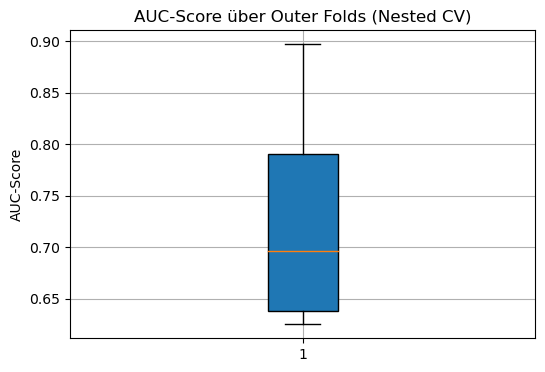

In [46]:
import matplotlib.pyplot as plt
print(nested_cv_scores)
plt.figure(figsize=(6, 4))
plt.boxplot(nested_cv_scores, vert=True, patch_artist=True)
plt.title('AUC-Score über Outer Folds (Nested CV)')
plt.ylabel('AUC-Score')
plt.grid(True)
plt.show()